In [1]:
import sys
sys.path.insert(0, '..//src')
sys.path.insert(0, '..//src//data')
sys.path.insert(0, '..//src//features')

import global_func as gf
import read_data
import data_preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
import pmdarima as pm

# Data Collection

In [2]:
#df_raw = read_data.load_csv(csv_name=r'..\data\raw\dataset_Q122.csv')
#gf.create_pkl(obj=df_raw, pkl=r'..\data\processed\df_raw.pkl')

df_raw = gf.load_pkl(pkl=r'..\data\processed\df_raw.pkl')
df_raw.head()

,lq45,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s
date,,,,,,,,,
2012-04-24,709.97,4170.35,358.94,30.88,137.31,3.2003,2.8412,1.2536,1.6128
2012-04-25,708.00,4163.64,357.35,30.88,139.19,3.0555,2.6918,1.9225,2.2862
2012-04-26,712.20,4180.31,359.55,31.13,140.16,3.3293,3.8457,2.8350,2.3186
2012-04-27,708.39,4163.98,357.52,31.14,140.39,3.5716,4.6417,3.7988,2.7288
2012-04-30,711.38,4180.73,359.05,30.93,139.87,2.8769,3.2943,2.5111,2.0937


# Data Definition & Validation

In [3]:
print(df_raw.info())
print()
print(df_raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2012-04-24 to 2022-03-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lq45    2416 non-null   float64
 1   jci     2416 non-null   float64
 2   idx30   2416 non-null   float64
 3   eido    2416 non-null   float64
 4   spy     2416 non-null   float64
 5   dom_b   2416 non-null   float64
 6   dom_s   2416 non-null   float64
 7   for_b   2416 non-null   float64
 8   for_s   2416 non-null   float64
dtypes: float64(9)
memory usage: 188.8 KB
None

lq45     0
jci      0
idx30    0
eido     0
spy      0
dom_b    0
dom_s    0
for_b    0
for_s    0
dtype: int64


## Resample data time-series: Interval = hari-kerja

In [3]:
DataPrep = data_preprocessing.DataPreprocessing()
df_proc = DataPrep.resampling(dataframe=df_raw, interval='B', resampling_method='median', fillna_method='ffill')
df_proc.tail()

,lq45,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s
date,,,,,,,,,
2022-03-25,1017.6660,7002.5322,544.181,24.79,452.69,8.6521,9.8707,4.9920,3.7734
2022-03-28,1026.8430,7049.6030,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587
2022-03-29,1019.0830,7011.6890,544.750,24.87,461.55,7.8961,8.9971,4.2180,3.1170
2022-03-30,1024.2159,7053.1899,547.368,24.81,458.70,9.0337,9.6315,4.7040,4.1061
2022-03-31,1022.9940,7071.4419,546.128,24.75,451.64,9.7775,10.5467,5.1009,4.3317


## Feature enriching

In [4]:
df_proc = DataPrep.enriching(dataframe=df_proc)
df_proc.tail()

,lq45,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s,dom_total,dom_net,for_total,for_net
date,,,,,,,,,,,,,
2022-03-25,1017.6660,7002.5322,544.181,24.79,452.69,8.6521,9.8707,4.9920,3.7734,18.5228,-1.2186,8.7654,1.2186
2022-03-28,1026.8430,7049.6030,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587,20.8568,-0.8578,7.5753,0.8579
2022-03-29,1019.0830,7011.6890,544.750,24.87,461.55,7.8961,8.9971,4.2180,3.1170,16.8932,-1.1010,7.3350,1.1010
2022-03-30,1024.2159,7053.1899,547.368,24.81,458.70,9.0337,9.6315,4.7040,4.1061,18.6652,-0.5978,8.8101,0.5979
2022-03-31,1022.9940,7071.4419,546.128,24.75,451.64,9.7775,10.5467,5.1009,4.3317,20.3242,-0.7692,9.4326,0.7692


# Data Splitting

In [5]:
#df_train, df_valid, df_test = DataPrep.splitting(dataframe=df_proc, train_end='2020-12-31', valid_end='2021-07-31')
#gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train.pkl')
#gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid.pkl')
#gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test.pkl')

df_train = gf.load_pkl(pkl=r'..\data\processed\df_train.pkl')
df_valid = gf.load_pkl(pkl=r'..\data\processed\df_valid.pkl')
df_test = gf.load_pkl(pkl=r'..\data\processed\df_test.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

# EDA

## Explorasi Target

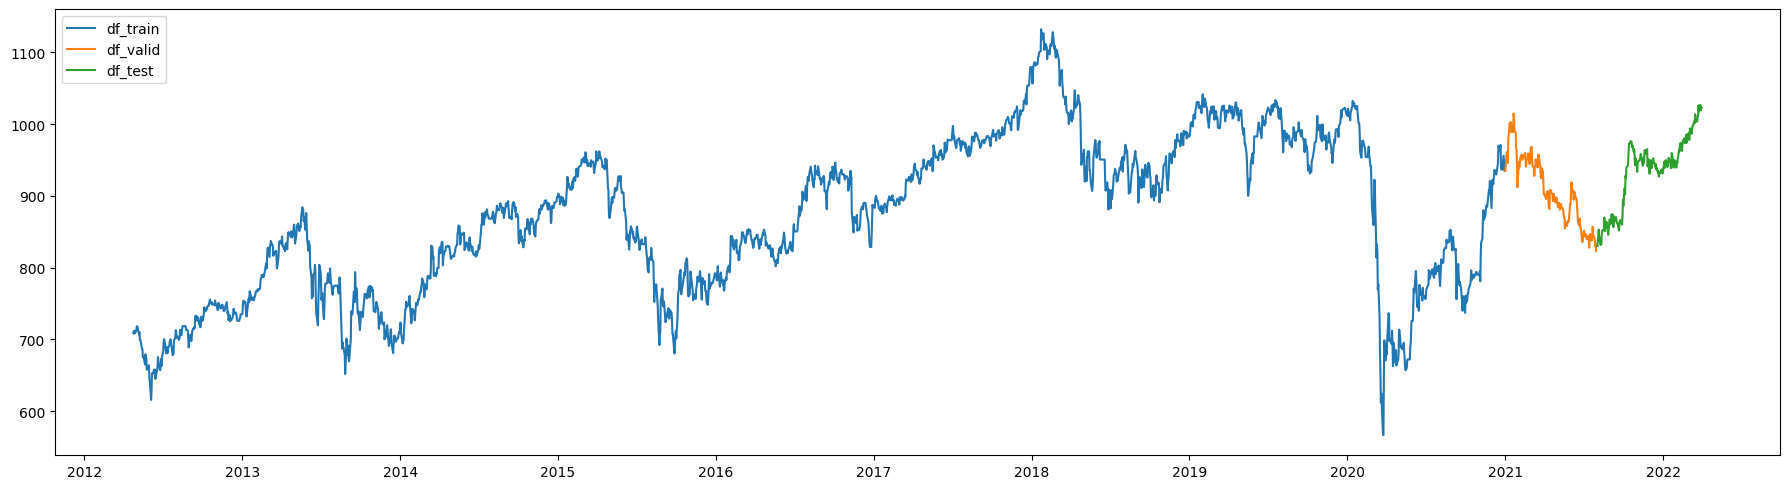

In [6]:
def plotting_target():
    fig = plt.figure(figsize=(18,5))
    for frame in [df_train, df_valid, df_test]:
        plt.plot(frame.index, frame['lq45'], label=frame.name)

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_target()

## Explorasi Tren

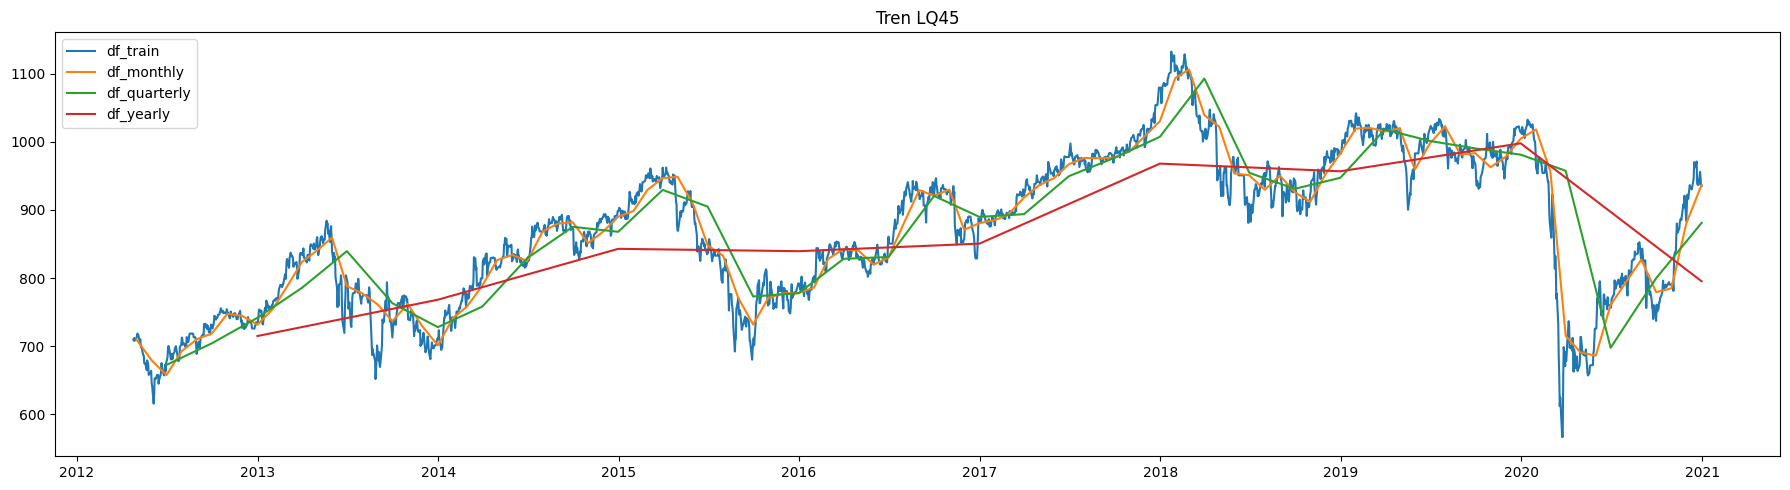

In [8]:
def plotting_tren(df):
    df_monthly = DataPrep.resampling(dataframe=df, interval='M', resampling_method='median', fillna_method='ffill')
    df_quarterly = DataPrep.resampling(dataframe=df, interval='Q', resampling_method='median', fillna_method='ffill')
    df_yearly = DataPrep.resampling(dataframe=df, interval='A', resampling_method='median', fillna_method='ffill')

    df_monthly.name = 'df_monthly'
    df_quarterly.name = 'df_quarterly'
    df_yearly.name = 'df_yearly'

    fig = plt.figure(figsize=(18,5))
    for frame in [df, df_monthly, df_quarterly, df_yearly]:
        plt.plot(frame.index, frame['lq45'], label=frame.name)

    plt.title('Tren LQ45')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_tren(df=df_train)

## Dekomposisi Seasonal

In [ ]:
#result_mul, df_seasonal = DataPrep.monthly_seasonal_feature(dataframe_train=df_train)
#gf.create_pkl(obj=df_seasonal, pkl=r'..\data\processed\df_seasonal.pkl')

result_mul,_ = DataPrep.monthly_seasonal_feature(dataframe_train=df_train)
df_seasonal = gf.load_pkl(pkl=r'..\data\processed\df_seasonal.pkl')
df_seasonal

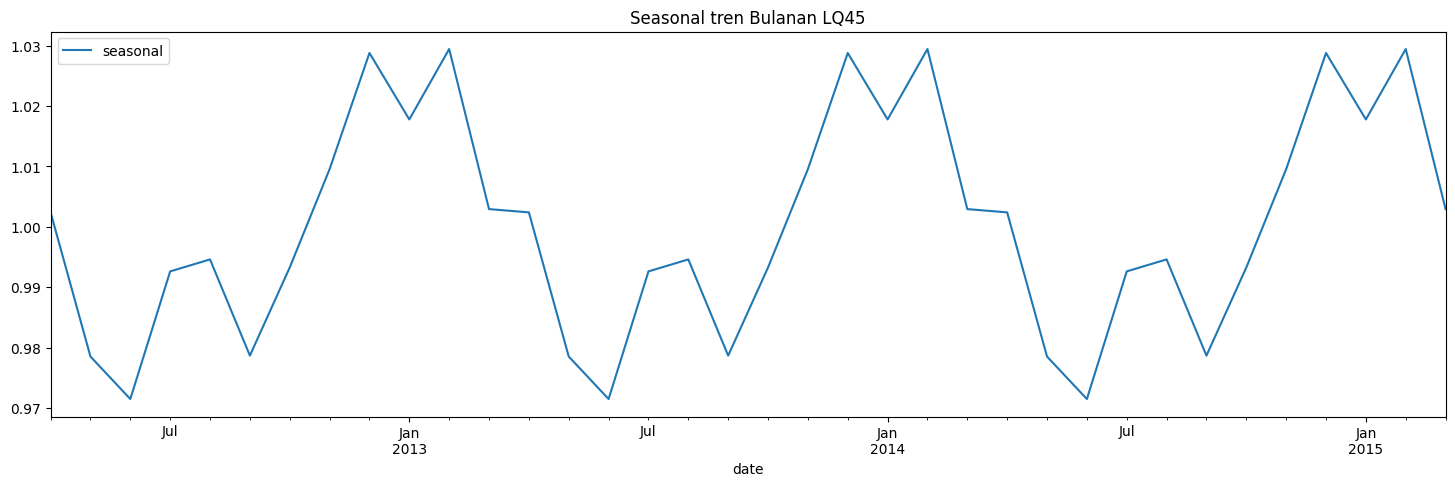

In [10]:
result_mul.seasonal[:36].to_frame().plot(subplots=True,figsize =(18,5))
plt.title('Seasonal tren Bulanan LQ45')
plt.show()

## Feature enriching (#2)

In [11]:
#df_train = DataPrep.enriching_seasonal(dataframe=df_train, df_seasonal=df_seasonal)
#df_valid = DataPrep.enriching_seasonal(dataframe=df_valid, df_seasonal=df_seasonal)
#df_test = DataPrep.enriching_seasonal(dataframe=df_test, df_seasonal=df_seasonal)
#gf.create_pkl(obj=df_train, pkl=r'..\data\processed\df_train.pkl')
#gf.create_pkl(obj=df_valid, pkl=r'..\data\processed\df_valid.pkl')
#gf.create_pkl(obj=df_test, pkl=r'..\data\processed\df_test.pkl')

df_train = gf.load_pkl(pkl=r'..\data\processed\df_train.pkl')
df_valid = gf.load_pkl(pkl=r'..\data\processed\df_valid.pkl')
df_test = gf.load_pkl(pkl=r'..\data\processed\df_test.pkl')

df_train.name = 'df_train'
df_valid.name = 'df_valid'
df_test.name = 'df_test'

## Cek stasioner

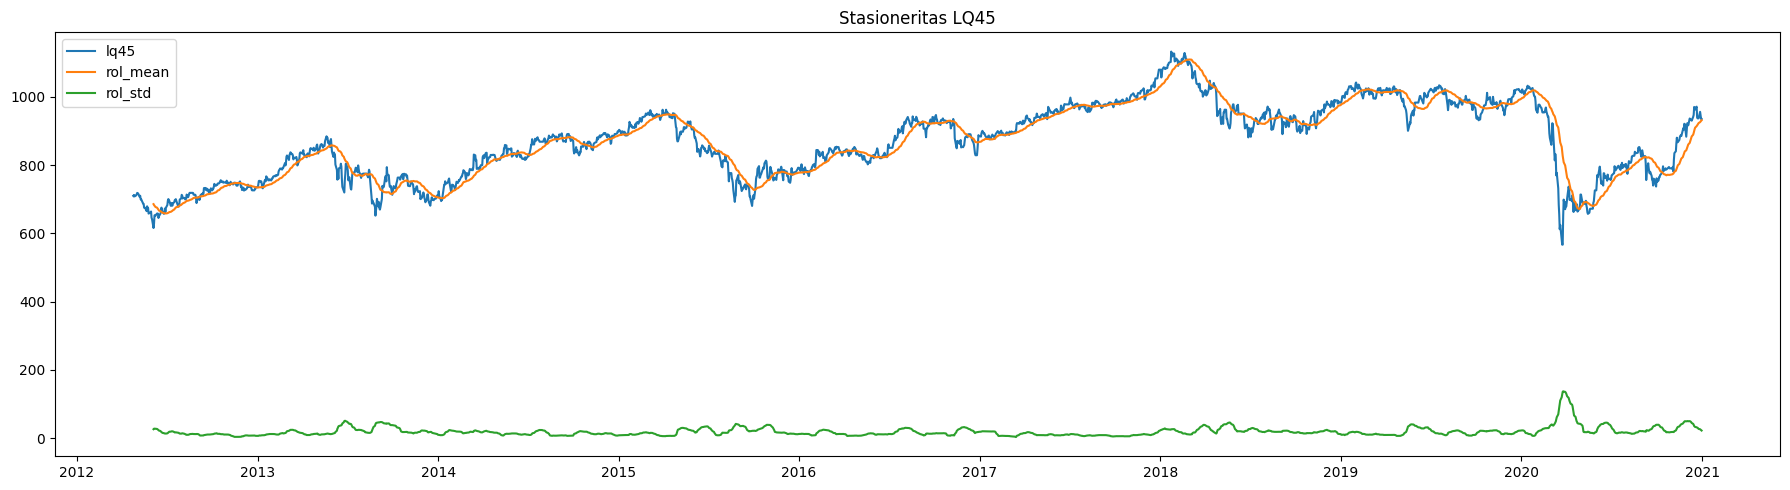

In [27]:
def plotting_stasioner(df):
    fig, axes = plt.subplots(figsize=[18, 5])

    rol_mean = df['lq45'].rolling(window = 30, center = False).mean()
    rol_std = df['lq45'].rolling(window = 30, center = False).std()

    axes.plot(df.index, df['lq45'], label='lq45')
    axes.plot(rol_mean, label='rol_mean')
    axes.plot(rol_std, label='rol_std')

    axes.set_title('Stasioneritas LQ45')
    axes.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plotting_stasioner(df=df_train)

## Plotting: Histogram

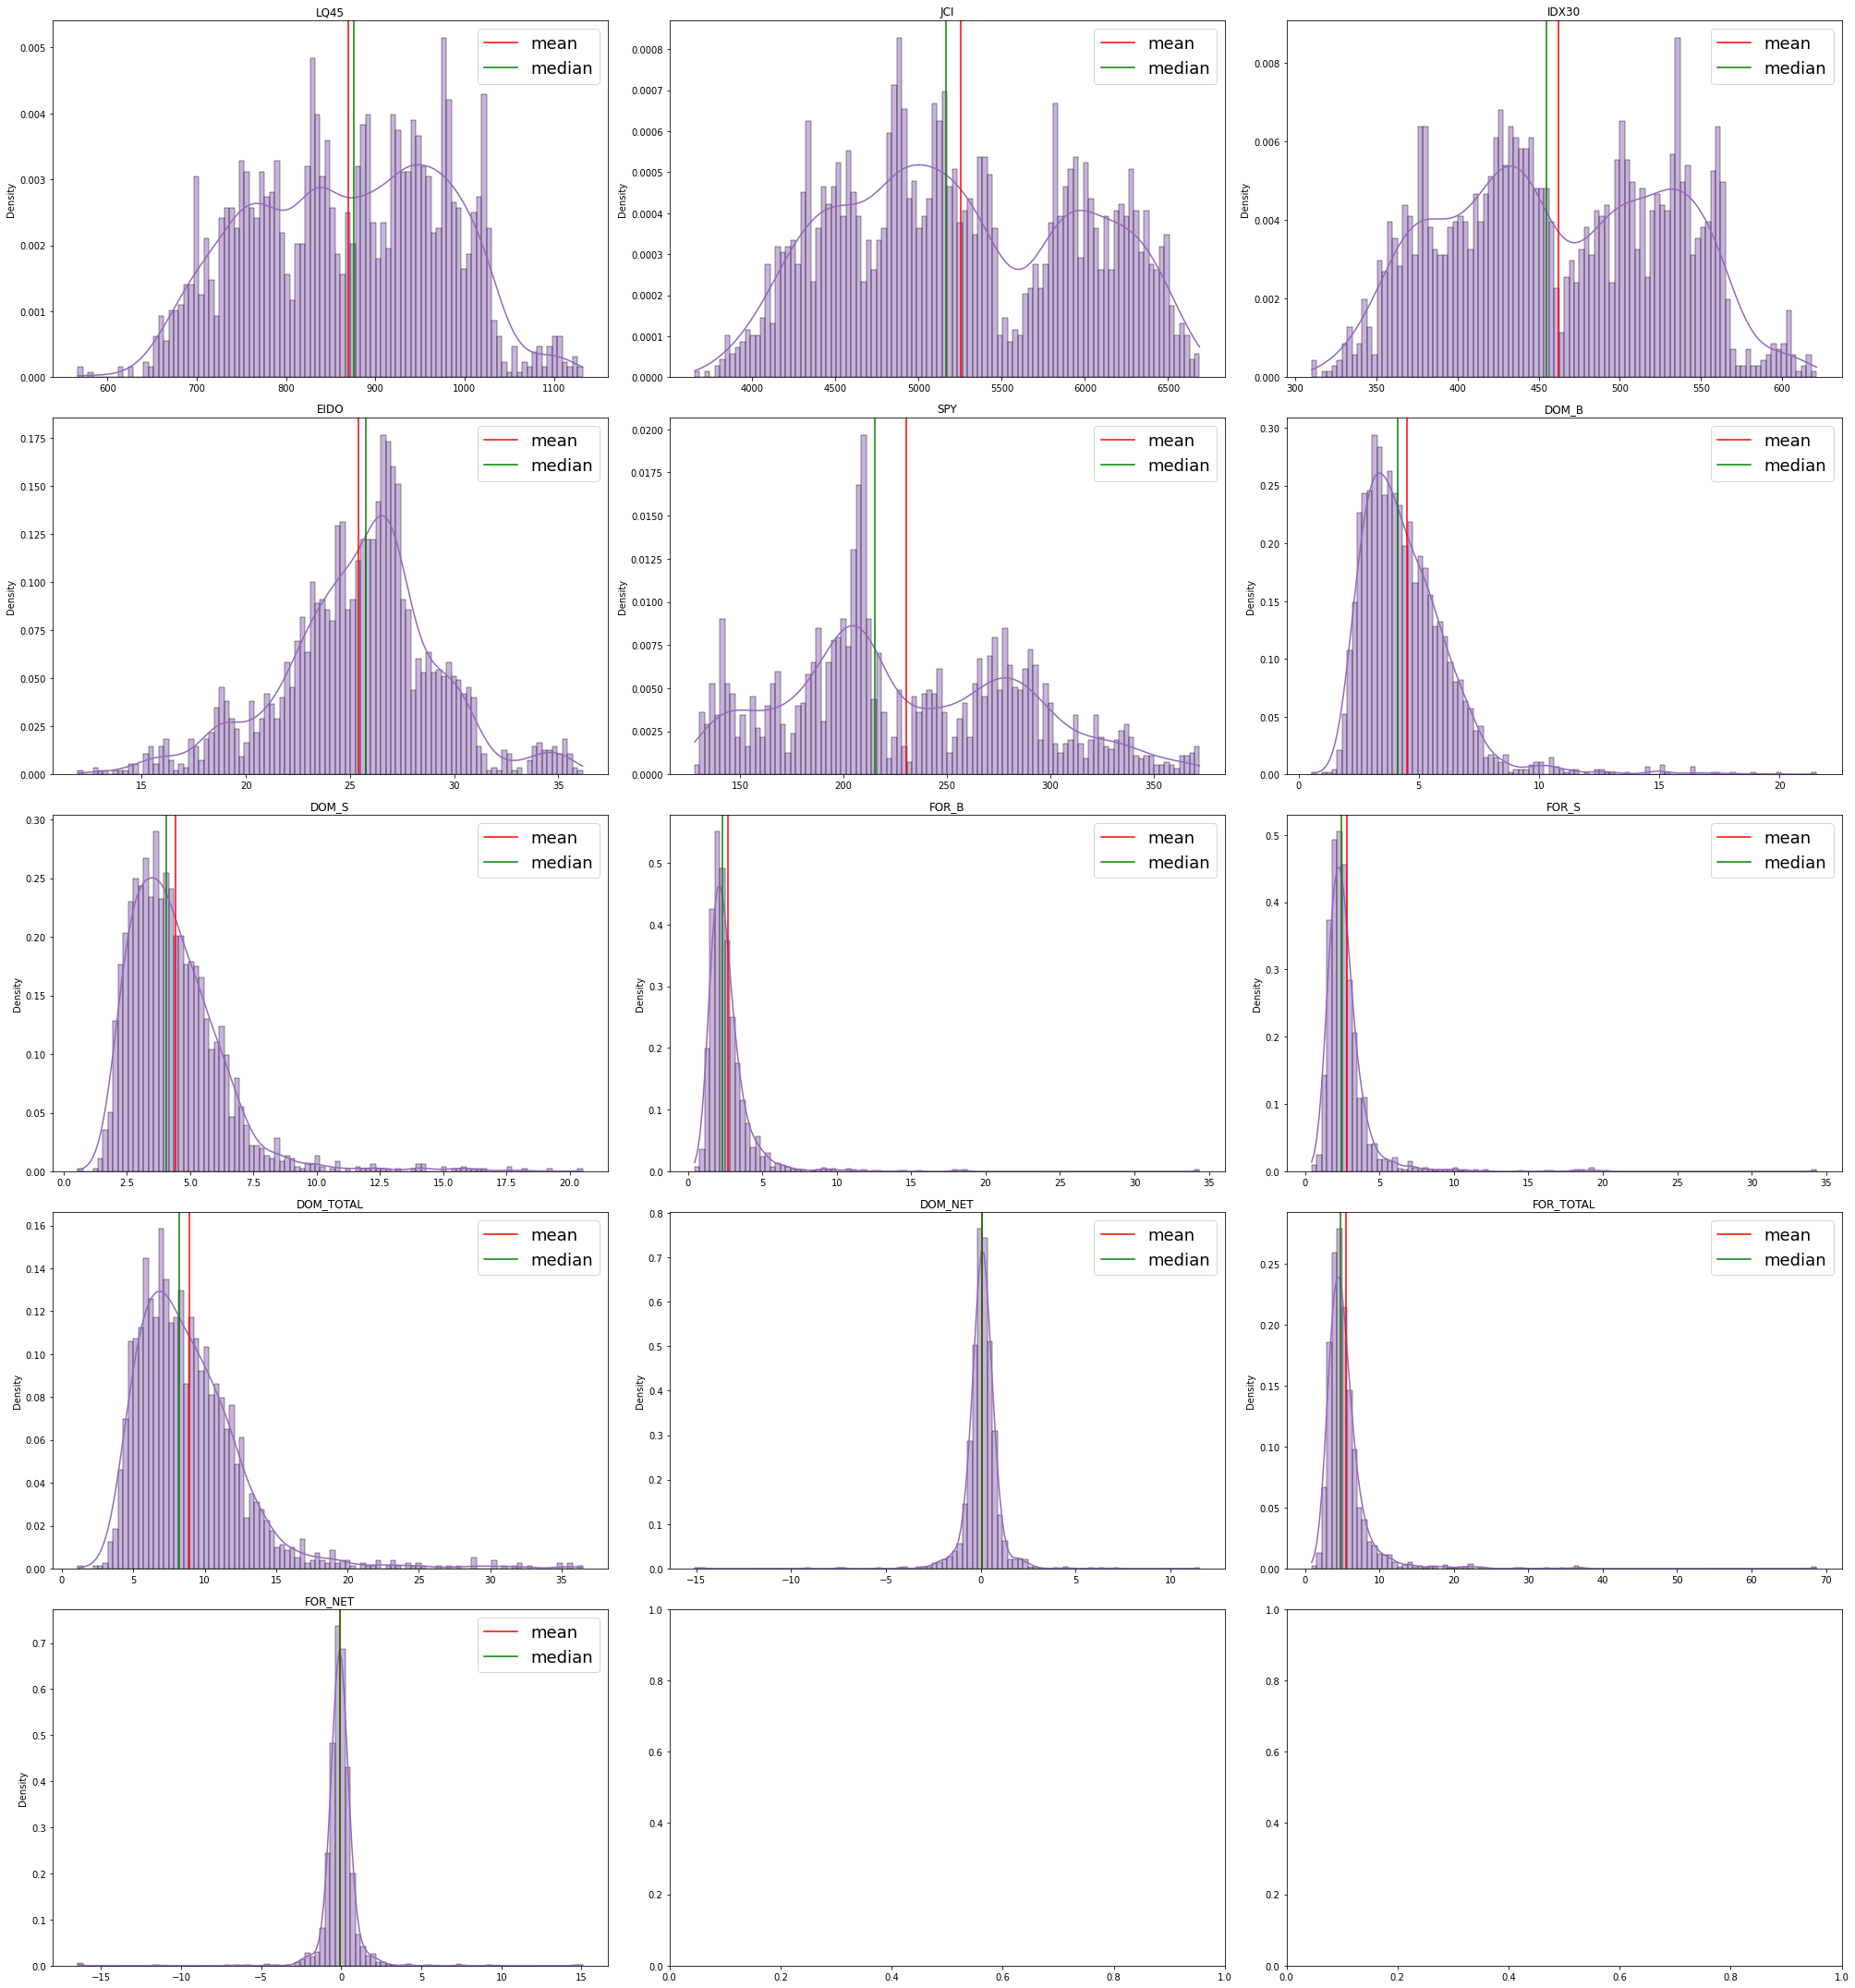

In [58]:
fig, axes = plt.subplots(nrows=5
                        ,ncols=3
                        ,figsize=[28, 30]
                        ,dpi=72
                        )

for i,ax in enumerate(axes.flatten()):
    try:
        if i >= len(df_train.columns):
            pass
        else:
            ax.set_title(f'{df_train.columns[i].upper()}')
            sns.histplot(data=df_train, x=df_train.columns[i], ax=ax, kde=True, bins=100, stat='density', color=sns.color_palette()[4])
            ax.axvline(x=df_train[df_train.columns[i]].mean(),color='red',ls='-',label='mean')
            ax.axvline(x=df_train[df_train.columns[i]].median(),color='green',ls='-',label='median')
            ax.set_xlabel('')
            ax.legend(fontsize=18)
    except Exception as e:
        print(f"ERROR : {str(e)}")

plt.tight_layout()
plt.show(block=False)

## Plotting: Boxplot

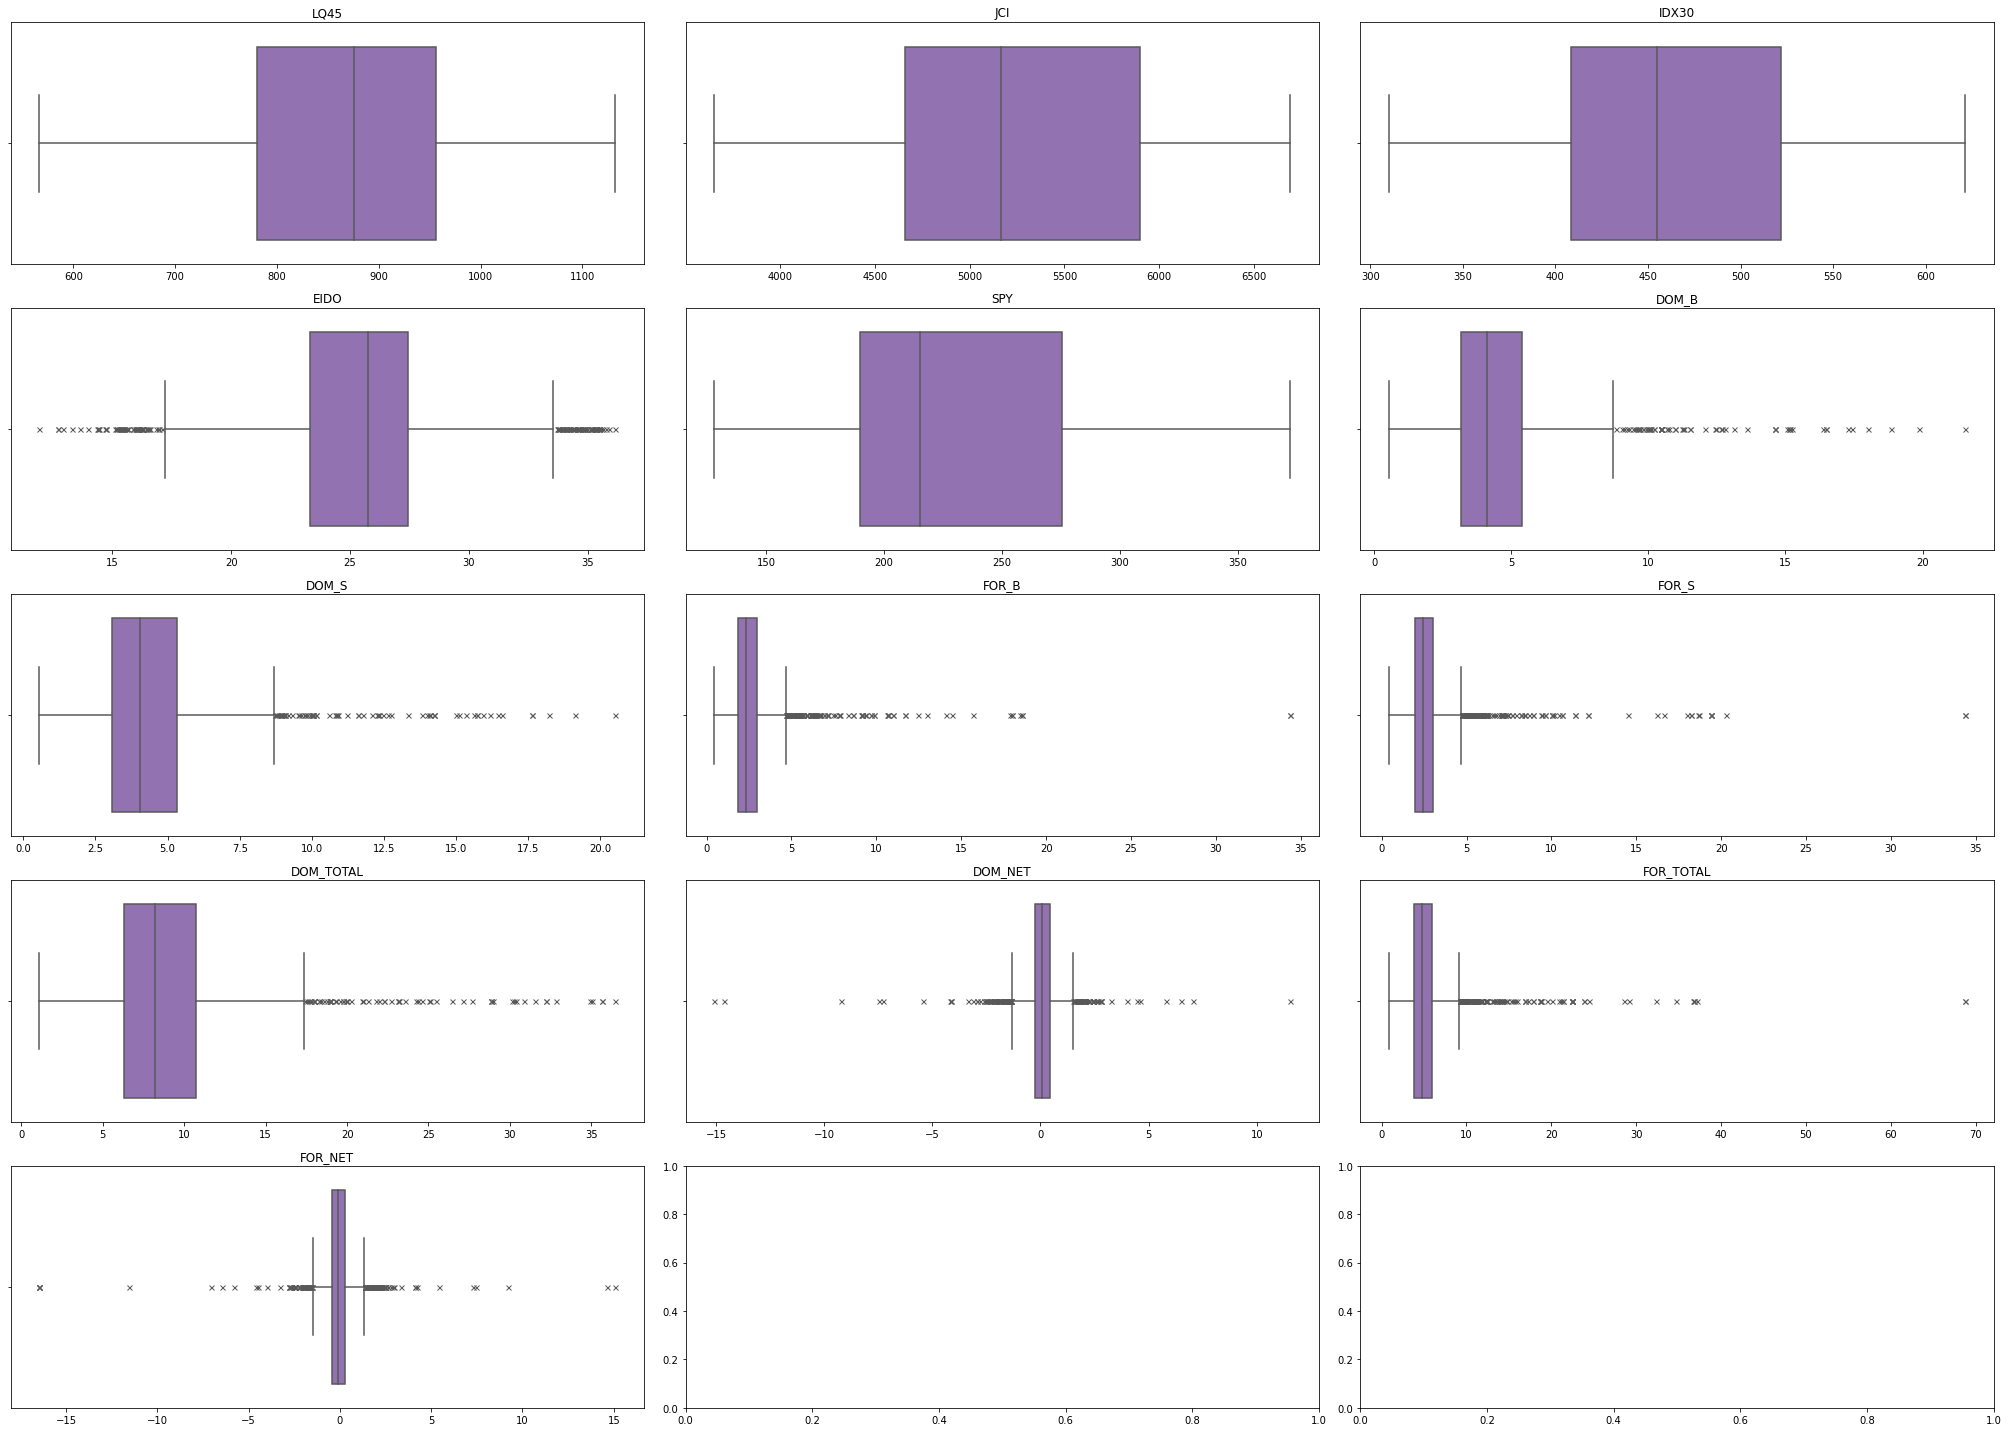

In [59]:
fig, axes = plt.subplots(nrows=5
                        ,ncols=3
                        ,figsize=[28, 20]
                        ,dpi=72
                        )

for i,ax in enumerate(axes.flatten()):
    try:
        if i >= len(df_train.columns):
            pass
        else:
            ax.set_title(f'{df_train.columns[i].upper()}')
            sns.boxplot(data=df_train, x=df_train.columns[i], ax=ax, flierprops={"marker": "x"}, color=sns.color_palette()[4])
            ax.set_xlabel('')
    except Exception as e:
        print(f"ERROR : {str(e)}")

plt.tight_layout()
plt.show(block=False)

## Heatmap

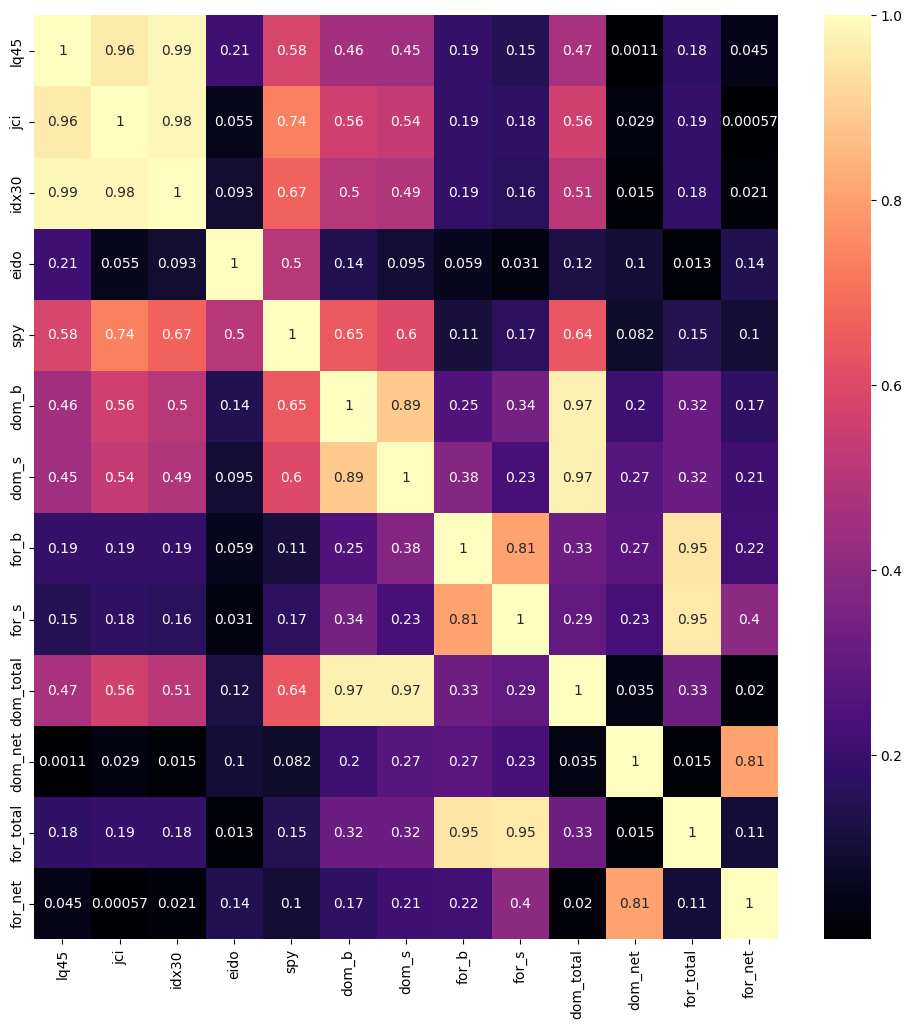

In [100]:
df_train_corr = df_train.reset_index().copy()
df_train_corr = df_train_corr.loc[:,df_train_corr.columns != 'date'].copy()
df_train_corr = df_train_corr.corr(method="pearson").abs()

plt.figure(figsize=(12,12))
sns.heatmap(df_train_corr, annot=True, cmap='magma')
plt.show()

In [103]:
df_train_corr
print(df_train_corr[df_train_corr['lq45'] >= 0.5]['lq45'])
print(df_train_corr[df_train_corr['dom_total'] >= 0.5]['dom_total'])

lq45     1.000000
jci      0.960736
idx30    0.987772
spy      0.578560
Name: lq45, dtype: float64
jci          0.563898
idx30        0.509540
spy          0.640551
dom_b        0.971003
dom_s        0.971949
dom_total    1.000000
Name: dom_total, dtype: float64


## Plotting: Tren

In [ ]:
fig, axes = plt.subplots(nrows=5
                        ,ncols=3
                        ,figsize=[28, 20]
                        ,dpi=72
                        )

for i,ax in enumerate(axes.flatten()):
    try:
        ax.set_title(f'Tren {df_proc.columns[i].upper()}')
        sns.lineplot(data=df_proc, x='date', y=df_proc.columns[i], ax=ax, label='Original')
        sns.lineplot(data=df_proc, x='date', y=df_proc[df_proc.columns[i]].rolling(window=80).mean(), ax=ax, label='Tren 4-Bulanan')
        sns.lineplot(data=df_proc, x='date', y=df_proc[df_proc.columns[i]].rolling(window=360).mean(), ax=ax, label='Tren Tahunan')
        ax.set_xlabel('')
        ax.set_ylabel(f'{df_proc.columns[i].upper()}')
        ax.legend(loc='upper left')  
    except:
        pass

plt.show(block=False)

In [ ]:
df_proc.loc[:,df_proc.columns[:-3]].plot(subplots=True,figsize =(18,24))
plt.show()

## Resampling: Monthly

In [ ]:
df_proc.plot(subplots=True,figsize =(18,24))
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df_pre['lq45'],#[7:372],   # 3 years
                                #model='additive', 
                                model='multiplicative', 
                                period=360,
                                extrapolate_trend='freq'
                                )

result_mul.seasonal[:720].to_frame().plot(subplots=True,figsize =(18,5))
result_mul.plot()

In [ ]:
df_train=df_pre[(df_pre.index.get_level_values(0) <= '2020-12-31')]
df_test=df_pre[(df_pre.index.get_level_values(0) > '2020-12-31') & (df_pre.index.get_level_values(0) <= '2021-03-31')]

In [ ]:
'''
model = pm.auto_arima(df_pre['lq45'], 
                         m=12, seasonal=True,
                         start_P=1, 
                         max_P=7,
                         start_Q=2,
                         max_Q=20,
                         #max_order=20, 
                         test='adf',
                         error_action='ignore',  
                         suppress_warnings=True,
                         stepwise=True, trace=True)
'''
model = pm.auto_arima(df_train['lq45'], 
                        X=df_train.loc[:, df_train.columns[1:]],
                        test='adf',
                        m=12, seasonal=True,
                        start_p=1, start_q=1,
                        max_p=3, max_q=3, 
                        start_P=0, 
                        d=None, D=1,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
print(model.summary())

In [ ]:
model.fit(df_train['lq45'])
forecast = model.predict(n_periods=len(df_test), 
                            #exogenous=df_pre.loc[:, df_pre.columns[1:]],
                            return_conf_int=True)
df_forecast = pd.concat([df_test['lq45'].reset_index(),
                        pd.DataFrame(forecast[0], columns=['prediction']).reset_index(drop=True)],
                        axis=1).set_index('date')
df_forecast.tail(20)

In [ ]:
df_forecast.plot(figsize =(15,4))
pyplot.show()



In [ ]:
# Forecast
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()